In [49]:
import torch
def grad_to_vector():
    vec = []
    for n,p in params.items():
        if p.grad is not None:
            vec.append(p.grad.view(-1))
        else:
            # Part of the network might has no grad, fill zero for those terms
            vec.append(p.data.clone().fill_(0).view(-1))
    return torch.cat(vec)

def vector_to_grad(vec):
    # Overwrite current param.grad by slicing the values in vec (flatten grad)
    pointer = 0
    for n, p in self.params.items():
        # The length of the parameter
        num_param = p.numel()
        if p.grad is not None:
            # Slice the vector, reshape it, and replace the old data of the grad
            p.grad.copy_(vec[pointer:pointer + num_param].view_as(p))
            # Part of the network might has no grad, ignore those terms
        # Increment the pointer
        pointer += num_param

def normalize_grad(input, p=2, dim=1, eps=1e-12):
    return input / input.norm(p, dim, True).clamp(min=eps).expand_as(input)
    
    
def skew(t):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).
    :param t: a :class:`Tensor`
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t))/torch.std(t))**3)

######################################################
# This the funciton which needs to be optimized.
###################################################### 
def update_(model, criterion, mem_loader,\
             train_loader, task): 
    import copy
    mem_iter = iter(mem_loader)
    for data_t in train_loader:
        if task>0:
            
            try:
                data_m= next(mem_iter)
            except StopIteration:
                mem_iter = iter(mem_loader)
                data_m= next(mem_iter)
            out = model(data_t.x.float(), data_t.edge_index, data_t.batch)  # Perform a single forward pass.
            out_m = model(data_m.x.float(), data_m.edge_index, data_m.batch) 
            J_P = criterion(out, data_t.y)
            J_M = criterion(out_m, data_m.y)
            Total_loss = 0.7*torch.mean(J_P) + 0.7*torch.var(J_P)\
                       + torch.mean(J_M)     + torch.var(J_M)
            
            
            # Add J_x  now
            J_PN_x=criterion(model(data_m.x.float(), data_m.edge_index, data_m.batch), data_m.y)
            x_PN = copy.copy(data_m.x) 
            x_PN.requires_grad = True
            adv_grad = 0
            epsilon = 0.0001
            for epoch in range(2): 
                x_PN = x_PN+ epsilon*adv_grad 
                crit = criterion(model(x_PN.float(), data_m.edge_index, data_m.batch), data_m.y)
                loss = torch.mean(crit) + torch.var(crit) # + skew(crit) + kurtosis(crit)
                adv_grad = torch.autograd.grad( loss,x_PN)[0]
                # Normalize the gradient values.
                adv_grad = normalize_grad(adv_grad, p=2,\
                    dim=1, eps=1e-12)
            ############## This is the loss MOMENT
            #########################################################################################    
            J_x_crit = (criterion(model(x_PN.float(), data_m.edge_index, data_m.batch), data_m.y) -J_PN_x)
            J_x = torch.mean(J_x_crit) + torch.var(J_x_crit) 
            Total_loss+= J_x + torch.var(J_x_crit) #+skew(critti)+ kurtosis(critti)# Compute the loss.     
            
            
            #Add J_\theta now
            #             ############## This is the loss MOMENT
            #########################################################################################    

            cop = copy.deepcopy(model)
            opt_buffer = torch.optim.Adam(cop.parameters(),lr = 0.001)
            J_PN_theta = criterion(model(data_m.x.float(), data_m.edge_index, data_m.batch), data_m.y) 
            for i in range(2):
                opt_buffer.zero_grad()
                loss_crit = criterion(cop(data_t.x.float(), data_t.edge_index, data_t.batch), data_t.y)
                loss_m = torch.mean(loss_crit) + torch.var(loss_crit) 
                #+ torch.var(loss_crit) + skew(loss_crit) + kurtosis(loss_crit)
                loss_m.backward(retain_graph=True)
                opt_buffer.step()
    
            J_th_crit = criterion(cop(data_m.x.float(), data_m.edge_index, data_m.batch), data_m.y) - J_PN_theta
            J_th = torch.mean(J_th_crit) + torch.var(J_th_crit) 
            Total_loss+=0.6*J_th
            optimizer.zero_grad() 
            Total_loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
        else:
            out = model(data_t.x.float(), data_t.edge_index, data_t.batch)  # Perform a single forward pass.
            critti= criterion(out, data_t.y)
            Total_loss = torch.mean(critti)+ torch.var(critti)
            #+ 0*torch.var(critti) + skew(critti)+ kurtosis(critti)# Compute the loss.
            optimizer.zero_grad() 
            Total_loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            
    if task>0:
        return (torch.mean(J_P)+torch.mean(J_M)+ torch.var(J_P)+\
                torch.var(J_M) +J_th+J_x).detach(),J_th.detach(),\
                (J_x+torch.mean(J_P)+torch.var(J_P)).detach()
    else:
        return Total_loss.detach(), Total_loss.detach(), Total_loss.detach()


new task graph_all_casa_nowcast_8
Number of training graphs: 738
Number of valid graphs: 246
Number of test graphs: 246
Memory:  Number of training graphs: 738
Memory:  Number of valid graphs: 246
Memory:  Number of test graphs: 246
#########################################################################
Epoch: 010, Train Acc: 0.3415, Test Acc: 0.3374
Mem Train Acc: 0.3415, Mem Test Acc: 0.3374
#########################################################################
#########################################################################
Epoch: 020, Train Acc: 0.5122, Test Acc: 0.5203
Mem Train Acc: 0.5122, Mem Test Acc: 0.5203
#########################################################################
#########################################################################
Epoch: 030, Train Acc: 0.5298, Test Acc: 0.5325
Mem Train Acc: 0.5298, Mem Test Acc: 0.5325
#########################################################################
###############################################

#########################################################################
Epoch: 350, Train Acc: 0.6911, Test Acc: 0.7033
Mem Train Acc: 0.6911, Mem Test Acc: 0.7033
#########################################################################
#########################################################################
Epoch: 360, Train Acc: 0.7209, Test Acc: 0.7154
Mem Train Acc: 0.7209, Mem Test Acc: 0.7154
#########################################################################
#########################################################################
Epoch: 370, Train Acc: 0.7304, Test Acc: 0.6911
Mem Train Acc: 0.7304, Mem Test Acc: 0.6911
#########################################################################
#########################################################################
Epoch: 380, Train Acc: 0.7317, Test Acc: 0.6870
Mem Train Acc: 0.7317, Mem Test Acc: 0.6870
#########################################################################
########################################

#########################################################################
Epoch: 700, Train Acc: 0.8184, Test Acc: 0.7846
Mem Train Acc: 0.8184, Mem Test Acc: 0.7846
#########################################################################
#########################################################################
Epoch: 710, Train Acc: 0.8144, Test Acc: 0.7683
Mem Train Acc: 0.8144, Mem Test Acc: 0.7683
#########################################################################
#########################################################################
Epoch: 720, Train Acc: 0.8089, Test Acc: 0.7846
Mem Train Acc: 0.8089, Mem Test Acc: 0.7846
#########################################################################
#########################################################################
Epoch: 730, Train Acc: 0.8089, Test Acc: 0.7764
Mem Train Acc: 0.8089, Mem Test Acc: 0.7764
#########################################################################
########################################

#########################################################################
Epoch: 1050, Train Acc: 0.8482, Test Acc: 0.8008
Mem Train Acc: 0.8482, Mem Test Acc: 0.8008
#########################################################################
#########################################################################
Epoch: 1060, Train Acc: 0.8496, Test Acc: 0.8211
Mem Train Acc: 0.8496, Mem Test Acc: 0.8211
#########################################################################
#########################################################################
Epoch: 1070, Train Acc: 0.7873, Test Acc: 0.8049
Mem Train Acc: 0.7873, Mem Test Acc: 0.8049
#########################################################################
#########################################################################
Epoch: 1080, Train Acc: 0.8550, Test Acc: 0.8171
Mem Train Acc: 0.8550, Mem Test Acc: 0.8171
#########################################################################
####################################

#########################################################################
Epoch: 1390, Train Acc: 0.8144, Test Acc: 0.8008
Mem Train Acc: 0.8144, Mem Test Acc: 0.8008
#########################################################################
#########################################################################
Epoch: 1400, Train Acc: 0.8645, Test Acc: 0.7805
Mem Train Acc: 0.8645, Mem Test Acc: 0.7805
#########################################################################
#########################################################################
Epoch: 1410, Train Acc: 0.8266, Test Acc: 0.7358
Mem Train Acc: 0.8266, Mem Test Acc: 0.7358
#########################################################################
#########################################################################
Epoch: 1420, Train Acc: 0.8293, Test Acc: 0.8049
Mem Train Acc: 0.8293, Mem Test Acc: 0.8049
#########################################################################
####################################

#########################################################################
Epoch: 1730, Train Acc: 0.8740, Test Acc: 0.8049
Mem Train Acc: 0.8740, Mem Test Acc: 0.8049
#########################################################################
#########################################################################
Epoch: 1740, Train Acc: 0.8523, Test Acc: 0.7317
Mem Train Acc: 0.8523, Mem Test Acc: 0.7317
#########################################################################
#########################################################################
Epoch: 1750, Train Acc: 0.8659, Test Acc: 0.8252
Mem Train Acc: 0.8659, Mem Test Acc: 0.8252
#########################################################################
#########################################################################
Epoch: 1760, Train Acc: 0.8130, Test Acc: 0.6829
Mem Train Acc: 0.8130, Mem Test Acc: 0.6829
#########################################################################
####################################

#########################################################################
Epoch: 080, Train Acc: 0.6876, Test Acc: 0.6784
Mem Train Acc: 0.5768, Mem Test Acc: 0.6008
#########################################################################
#########################################################################
Epoch: 090, Train Acc: 0.6837, Test Acc: 0.6706
Mem Train Acc: 0.5795, Mem Test Acc: 0.5988
#########################################################################
#########################################################################
Epoch: 100, Train Acc: 0.6915, Test Acc: 0.6824
Mem Train Acc: 0.5875, Mem Test Acc: 0.6108
#########################################################################
#########################################################################
Epoch: 110, Train Acc: 0.6941, Test Acc: 0.6941
Mem Train Acc: 0.5862, Mem Test Acc: 0.6208
#########################################################################
########################################

#########################################################################
Epoch: 430, Train Acc: 0.7922, Test Acc: 0.7608
Mem Train Acc: 0.7013, Mem Test Acc: 0.6946
#########################################################################
#########################################################################
Epoch: 440, Train Acc: 0.7961, Test Acc: 0.7412
Mem Train Acc: 0.6793, Mem Test Acc: 0.6607
#########################################################################
#########################################################################
Epoch: 450, Train Acc: 0.7882, Test Acc: 0.7333
Mem Train Acc: 0.7219, Mem Test Acc: 0.7066
#########################################################################
#########################################################################
Epoch: 460, Train Acc: 0.8209, Test Acc: 0.7412
Mem Train Acc: 0.7219, Mem Test Acc: 0.6766
#########################################################################
########################################

#########################################################################
Epoch: 780, Train Acc: 0.9150, Test Acc: 0.8627
Mem Train Acc: 0.8543, Mem Test Acc: 0.8244
#########################################################################
#########################################################################
Epoch: 790, Train Acc: 0.9190, Test Acc: 0.8431
Mem Train Acc: 0.8184, Mem Test Acc: 0.7725
#########################################################################
#########################################################################
Epoch: 800, Train Acc: 0.9098, Test Acc: 0.8667
Mem Train Acc: 0.8623, Mem Test Acc: 0.8263
#########################################################################
#########################################################################
Epoch: 810, Train Acc: 0.8993, Test Acc: 0.8471
Mem Train Acc: 0.8297, Mem Test Acc: 0.8004
#########################################################################
########################################

#########################################################################
Epoch: 1130, Train Acc: 0.9399, Test Acc: 0.8902
Mem Train Acc: 0.9002, Mem Test Acc: 0.8543
#########################################################################
#########################################################################
Epoch: 1140, Train Acc: 0.9255, Test Acc: 0.8863
Mem Train Acc: 0.8616, Mem Test Acc: 0.8303
#########################################################################
#########################################################################
Epoch: 1150, Train Acc: 0.9255, Test Acc: 0.8824
Mem Train Acc: 0.8703, Mem Test Acc: 0.8303
#########################################################################
#########################################################################
Epoch: 1160, Train Acc: 0.9399, Test Acc: 0.8824
Mem Train Acc: 0.9022, Mem Test Acc: 0.8483
#########################################################################
####################################

#########################################################################
Epoch: 1470, Train Acc: 0.9438, Test Acc: 0.8980
Mem Train Acc: 0.8955, Mem Test Acc: 0.8423
#########################################################################
#########################################################################
Epoch: 1480, Train Acc: 0.9425, Test Acc: 0.8941
Mem Train Acc: 0.8609, Mem Test Acc: 0.7864
#########################################################################
#########################################################################
Epoch: 1490, Train Acc: 0.9386, Test Acc: 0.8980
Mem Train Acc: 0.8776, Mem Test Acc: 0.8323
#########################################################################
#########################################################################
Epoch: 1500, Train Acc: 0.9359, Test Acc: 0.8902
Mem Train Acc: 0.8869, Mem Test Acc: 0.8403
#########################################################################
####################################

#########################################################################
Epoch: 1810, Train Acc: 0.9425, Test Acc: 0.8863
Mem Train Acc: 0.9035, Mem Test Acc: 0.8383
#########################################################################
#########################################################################
Epoch: 1820, Train Acc: 0.9438, Test Acc: 0.8980
Mem Train Acc: 0.8989, Mem Test Acc: 0.8463
#########################################################################
#########################################################################
Epoch: 1830, Train Acc: 0.9412, Test Acc: 0.8980
Mem Train Acc: 0.9055, Mem Test Acc: 0.8703
#########################################################################
#########################################################################
Epoch: 1840, Train Acc: 0.9346, Test Acc: 0.8824
Mem Train Acc: 0.9009, Mem Test Acc: 0.8543
#########################################################################
####################################

#########################################################################
Epoch: 160, Train Acc: 0.6355, Test Acc: 0.6220
Mem Train Acc: 0.7581, Mem Test Acc: 0.7162
#########################################################################
#########################################################################
Epoch: 170, Train Acc: 0.6477, Test Acc: 0.6585
Mem Train Acc: 0.7604, Mem Test Acc: 0.7269
#########################################################################
#########################################################################
Epoch: 180, Train Acc: 0.6179, Test Acc: 0.6057
Mem Train Acc: 0.7568, Mem Test Acc: 0.7282
#########################################################################
#########################################################################
Epoch: 190, Train Acc: 0.6138, Test Acc: 0.5976
Mem Train Acc: 0.7755, Mem Test Acc: 0.7349
#########################################################################
########################################

#########################################################################
Epoch: 510, Train Acc: 0.6802, Test Acc: 0.6463
Mem Train Acc: 0.8028, Mem Test Acc: 0.7764
#########################################################################
#########################################################################
Epoch: 520, Train Acc: 0.6491, Test Acc: 0.5976
Mem Train Acc: 0.7871, Mem Test Acc: 0.7189
#########################################################################
#########################################################################
Epoch: 530, Train Acc: 0.5921, Test Acc: 0.5691
Mem Train Acc: 0.7537, Mem Test Acc: 0.7229
#########################################################################
#########################################################################
Epoch: 540, Train Acc: 0.6531, Test Acc: 0.6301
Mem Train Acc: 0.7751, Mem Test Acc: 0.7483
#########################################################################
########################################

#########################################################################
Epoch: 860, Train Acc: 0.7100, Test Acc: 0.6463
Mem Train Acc: 0.8264, Mem Test Acc: 0.7684
#########################################################################
#########################################################################
Epoch: 870, Train Acc: 0.6978, Test Acc: 0.6748
Mem Train Acc: 0.8050, Mem Test Acc: 0.7497
#########################################################################
#########################################################################
Epoch: 880, Train Acc: 0.6870, Test Acc: 0.6545
Mem Train Acc: 0.8010, Mem Test Acc: 0.7751
#########################################################################
#########################################################################
Epoch: 890, Train Acc: 0.6220, Test Acc: 0.5854
Mem Train Acc: 0.7724, Mem Test Acc: 0.7282
#########################################################################
########################################

#########################################################################
Epoch: 1210, Train Acc: 0.7087, Test Acc: 0.6748
Mem Train Acc: 0.8322, Mem Test Acc: 0.7764
#########################################################################
#########################################################################
Epoch: 1220, Train Acc: 0.6870, Test Acc: 0.6463
Mem Train Acc: 0.8126, Mem Test Acc: 0.7657
#########################################################################
#########################################################################
Epoch: 1230, Train Acc: 0.7209, Test Acc: 0.6911
Mem Train Acc: 0.8331, Mem Test Acc: 0.7644
#########################################################################
#########################################################################
Epoch: 1240, Train Acc: 0.6612, Test Acc: 0.5772
Mem Train Acc: 0.7639, Mem Test Acc: 0.7108
#########################################################################
####################################

#########################################################################
Epoch: 1550, Train Acc: 0.7466, Test Acc: 0.6667
Mem Train Acc: 0.8394, Mem Test Acc: 0.7751
#########################################################################
#########################################################################
Epoch: 1560, Train Acc: 0.7249, Test Acc: 0.6463
Mem Train Acc: 0.8295, Mem Test Acc: 0.7818
#########################################################################
#########################################################################
Epoch: 1570, Train Acc: 0.7466, Test Acc: 0.6789
Mem Train Acc: 0.8550, Mem Test Acc: 0.7979
#########################################################################
#########################################################################
Epoch: 1580, Train Acc: 0.7236, Test Acc: 0.6301
Mem Train Acc: 0.8237, Mem Test Acc: 0.7537
#########################################################################
####################################

#########################################################################
Epoch: 1890, Train Acc: 0.7439, Test Acc: 0.6504
Mem Train Acc: 0.8505, Mem Test Acc: 0.7791
#########################################################################
#########################################################################
Epoch: 1900, Train Acc: 0.7466, Test Acc: 0.6707
Mem Train Acc: 0.8474, Mem Test Acc: 0.7938
#########################################################################
#########################################################################
Epoch: 1910, Train Acc: 0.7466, Test Acc: 0.6545
Mem Train Acc: 0.8474, Mem Test Acc: 0.7885
#########################################################################
#########################################################################
Epoch: 1920, Train Acc: 0.7547, Test Acc: 0.6585
Mem Train Acc: 0.8608, Mem Test Acc: 0.7912
#########################################################################
####################################

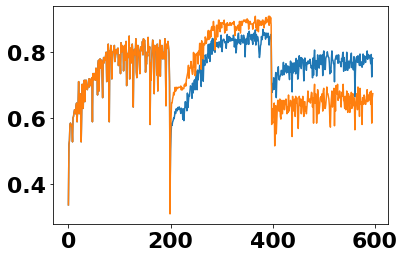

In [37]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_geometric.nn import global_mean_pool

def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x.float(), data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(14, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 4)
        

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.0001, training=self.training)
        x = self.lin2(x)
        return x

memory_train=[]
memory_test=[]
memory_valid=[]
filenames =['graph_all_casa_nowcast_8', 'graph_all_genome',\
            'graph_all_nowcluster_16', 'graph_all_wind_clustering', \
            'graph_all_wind_noclustering']
model = GCN(hidden_channels=64).float()
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#import torch.optim.lr_scheduler as lrs
#scheduler = lrs.ExponentialLR(optimizer, gamma=0.9)
accuracies_mem = []
accuracies_one=[]
Total_loss=[]
Gen_loss=[]
For_loss=[]
for (i,file) in enumerate(filenames):
    print("new task", file)
    # nowcast clustering
    # Import the file.
    import pickle
    with open('pickles/'+file+'.pkl','rb') as f:
        graphs= pickle.load(f) 
    # Separate the data according to labels
    # One for every type of workflow
    import numpy as np
    y_list = []
    for gr in graphs:
        y_list.append(gr['y'])
    tot = np.unique(np.array(y_list), return_counts=True)[1][1]
    import torch
    from torch_geometric.data import Data
    datasets=[]
    import numpy
    from sklearn.preprocessing import StandardScaler
    for element in graphs:
        gx = torch.tensor(numpy.array(element['x']) ) 
        ge =torch.tensor(numpy.array(element['edge_index']) ).T
        gy =torch.tensor(numpy.array(element['y']).reshape([-1]))
        v_min, v_max = gx.min(), gx.max()
        new_min, new_max = 0, 1
        gx = (gx - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
        # print(gx.min(), gx.max())
        datasets.append( Data(x=gx, edge_index=ge, y=gy) )
        
        
    import random
    torch.manual_seed(12345)
    random.seed(12345)
    lengtha=len(datasets)
    random.shuffle(datasets)
    train_dataset = datasets[:int(0.60*lengtha)]
    valid_dataset = datasets[int(0.60*lengtha):int(0.80*lengtha)]
    test_dataset = datasets[int(0.80*lengtha):]
    
    memory_train+=train_dataset
    memory_valid+=valid_dataset
    memory_test+=test_dataset
    
    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of valid graphs: {len(valid_dataset)}')
    print(f'Number of test graphs: {len(test_dataset)}')
    
    print(f'Memory:  Number of training graphs: {len(memory_train)}')
    print(f'Memory:  Number of valid graphs: {len(memory_valid)}')
    print(f'Memory:  Number of test graphs: {len(memory_test)}')


    from torch_geometric.loader import DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
    mem_train_loader = DataLoader(memory_train, batch_size=64, shuffle=True)
    mem_test_loader = DataLoader(memory_test, batch_size=64, shuffle=True)
    for epoch in range(1,2000):
        Total, Gen, For =update_(model, criterion, mem_train_loader,\
             train_loader, task=i)
        
        Total_loss.append(Total)
        Gen_loss.append(Gen)
        For_loss.append(For)
        
        if epoch%10==0:
            # scheduler.step()
            train_acc = test(train_loader)
            test_acc = test(test_loader)
            mem_train_acc = test(mem_train_loader)
            mem_test_acc = test(mem_test_loader)
            
            accuracies_mem.append(mem_test_acc)
            accuracies_one.append(test_acc)
            print("#########################################################################")
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
            print(f'Mem Train Acc: {mem_train_acc:.4f}, Mem Test Acc: {mem_test_acc:.4f}')
            print("#########################################################################")

import matplotlib.pyplot as plt
plt.plot(accuracies_mem, label='memory accuracy')
plt.plot(accuracies_one, label='task accuracy')


In [38]:
# np.savetxt('withExtra_X_theta_Loss.csv', np.concatenate([ np.array(Total_loss).reshape([-1,1]),\
#                                          np.array(Gen_loss).reshape([-1,1]),\
#                                          np.array(For_loss).reshape([-1,1])], axis =1))
np.savetxt('withExtra_X_theta_Loss_higher.csv', np.concatenate([ np.array(Total_loss).reshape([-1,1]),\
                                         np.array(Gen_loss).reshape([-1,1]),\
                                         np.array(For_loss).reshape([-1,1])], axis =1))

np.savetxt('withExtra_X_theta_Acc_higher.csv', np.concatenate([ np.array(accuracies_one).reshape([-1,1]),\
                                         np.array(accuracies_mem).reshape([-1,1])], axis =1))

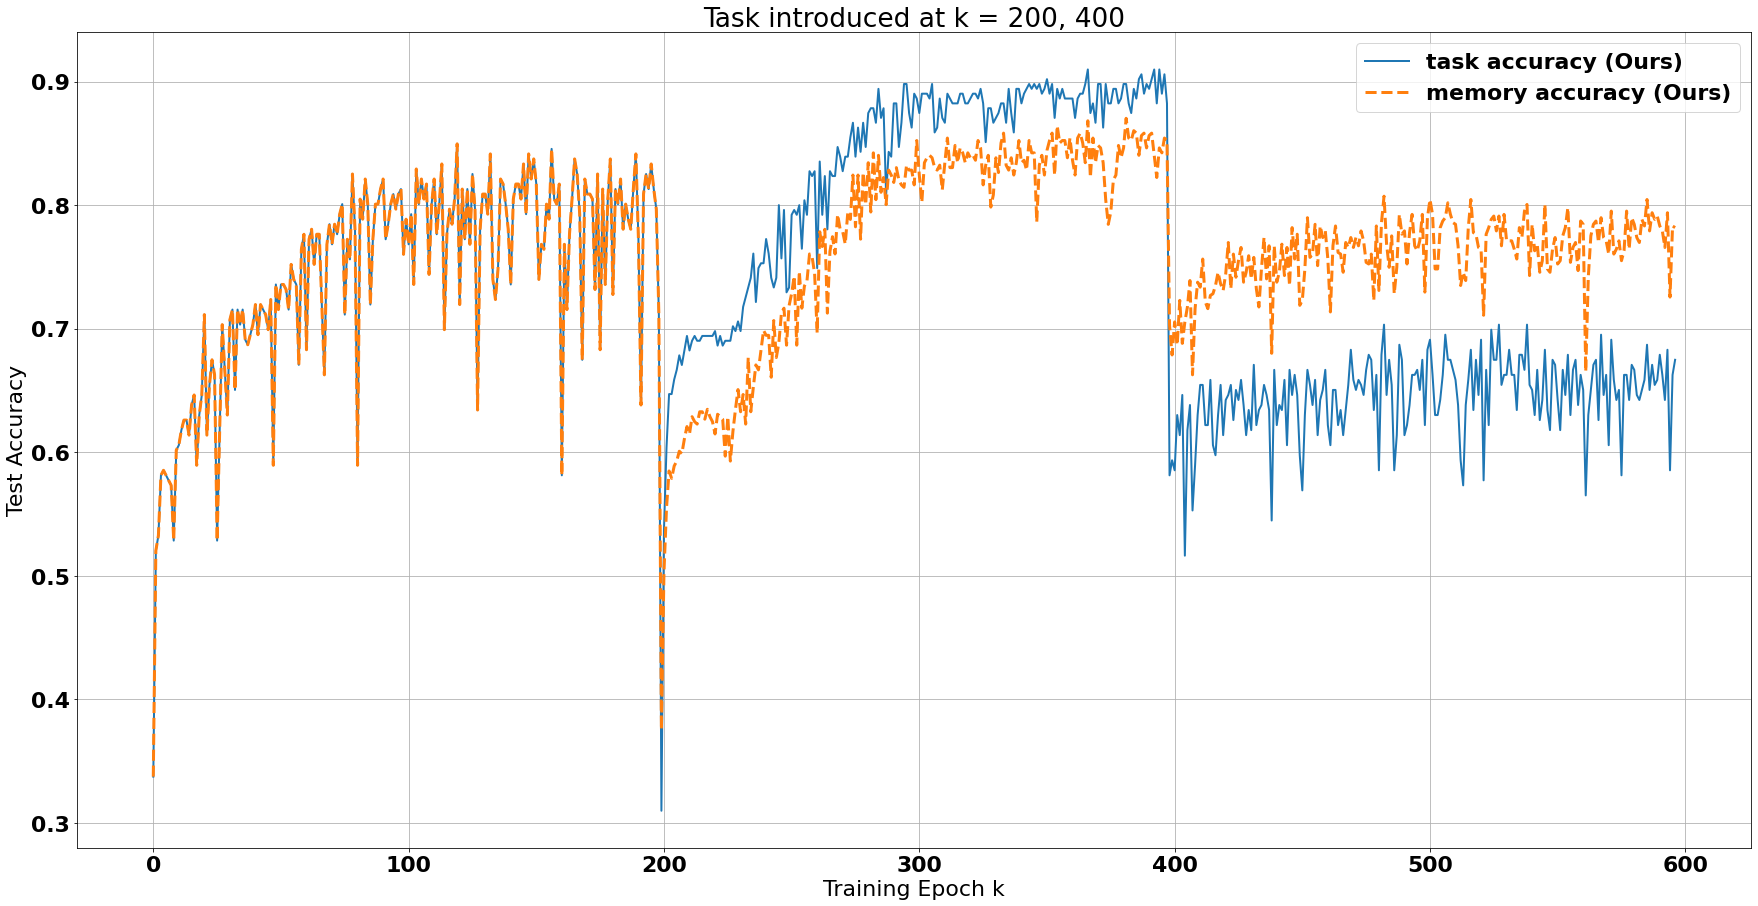

In [48]:
acc_old = np.loadtxt('blind.csv')
acc_mem = np.loadtxt('withMEM(EXP).csv')
acc_X = np.loadtxt('withExtra_X.csv')
acc_theta = np.loadtxt('withExtra_X_theta_Acc_higher.csv')
import matplotlib.pyplot as plt
import matplotlib
plt.figure(figsize=(30, 15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# plt.plot(acc_old[:,0],label='memory accuracy (Naive)', lw = 2)
#plt.plot(acc_mem[:,0], label='task accuracy (Experience Replay)', lw = 2)
#plt.plot(acc_X[:,0], label='memory accuracy (J_x)', lw = 2)
plt.plot(acc_theta[:,0], label='task accuracy (Ours)', lw = 2)

#plt.plot(acc_old[:,1],'--', label='task accuracy (Naive)', lw = 3)
#plt.plot(acc_mem[:,1], '--', label='memory accuracy (Experience Replay)', lw = 3)
#plt.plot(acc_X[:,1], '--', label='task accuracy (J_x)', lw = 3)
plt.plot(acc_theta[:,1], '--', label='memory accuracy (Ours)', lw = 3)

plt.xlabel('Training Epoch k')
plt.ylabel('Test Accuracy')
plt.title('Task introduced at k = 200, 400')
plt.grid('True')
plt.legend()
plt.show()

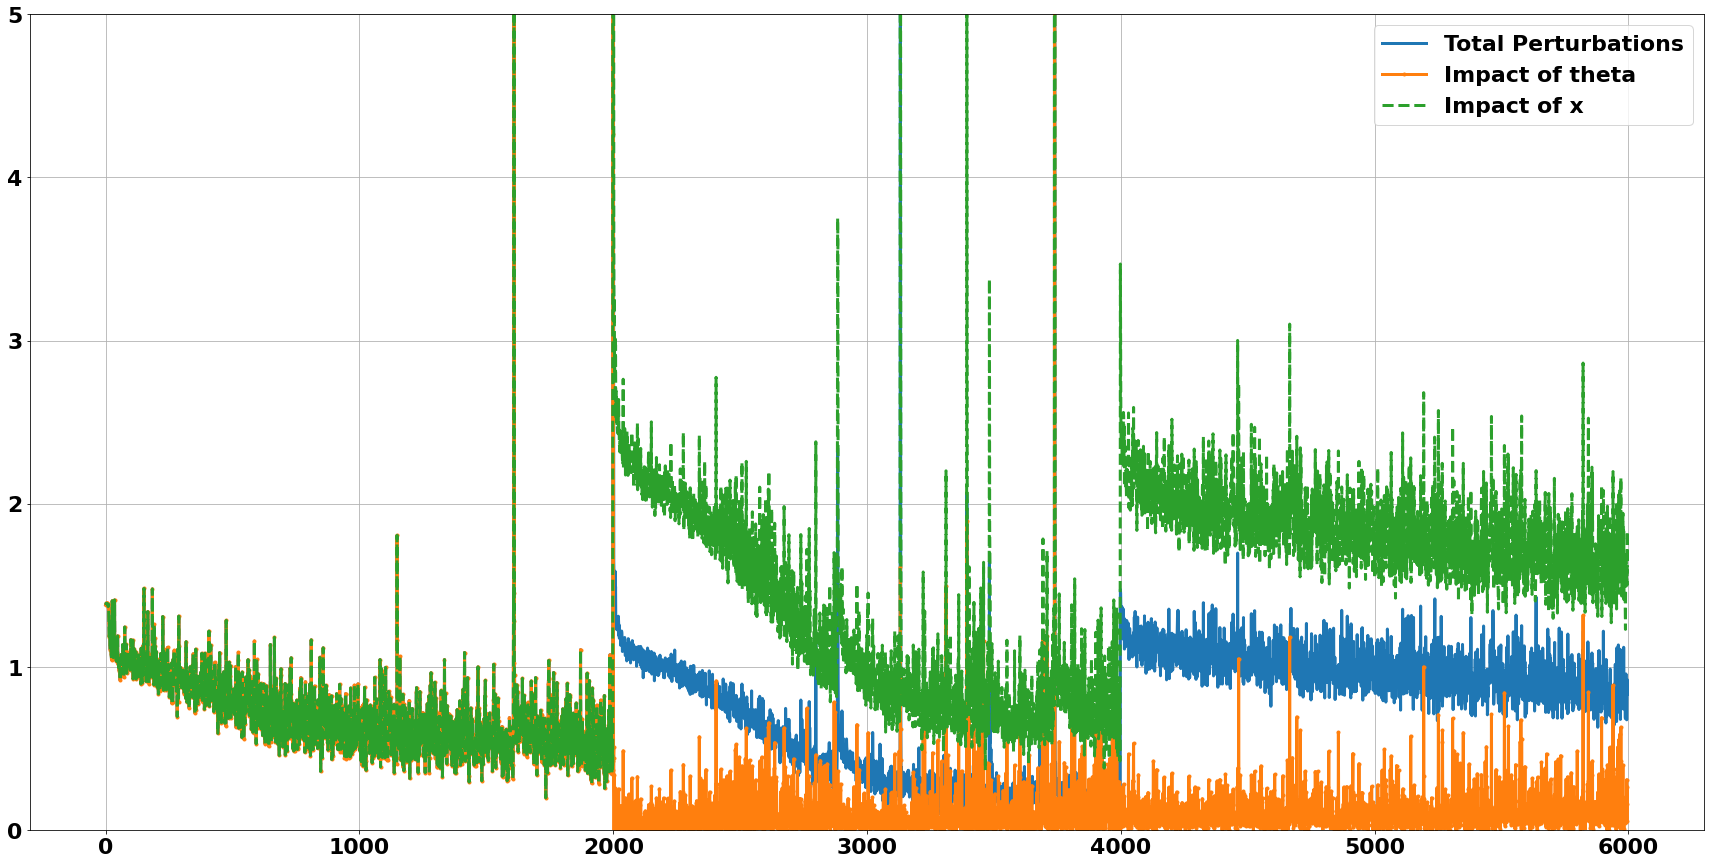

In [47]:
Losses= np.loadtxt('withExtra_X_theta_Loss_higher.csv')


import matplotlib.pyplot as plt
import matplotlib
plt.figure(figsize=(30, 15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

#plt.plot(acc_old[:,1],'--', label='task accuracy (Naive)', lw = 3)
plt.plot(Losses[:,2], label='Total Perturbations', lw = 3)
plt.plot(Losses[:,1], '.-', label='Impact of theta', lw = 3)
plt.plot(Losses[:,0], '--', label='Impact of x', lw = 3)
plt.legend()
plt.ylim([0,5])
plt.grid(True)
plt.show()